In [ ]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np
import random
from typing import Callable, Iterable, List, Dict, Optional, Tuple
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from __future__ import annotations
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
""" We will start with analysing the system using imitate first, we will test our policy suggestion in logit as well to see if it still
    performs well under more realsitic, noisy behaviour """

def choose_strategy_imitate(agent, neighbors):
    """Choose strategy of the highest-payoff neighbour (including self)."""
    candidates = neighbors + [agent]
    best = max(candidates, key=lambda a: a.payoff)
    return best.strategy

def choose_strategy_logit(agent, neighbors, a_I, b, tau):
    """Choose strategy using logit / softmax choice.

    Parameters
    - agent: the agent choosing a strategy
    - neighbors: list of neighbour agents
    - a_I: effective coordination payoff given current infrastructure
    - b: defection payoff
    - tau: temperature parameter for softmax
    """
    # compute expected payoffs for C and D 
    """ Still have to do determine C and D pi! """
    pi_C = 0.0
    pi_D = 0.0
    for other in neighbors:
        s_j = other.strategy
        if s_j == "C":
            pi_C += a_I
            pi_D += b
        else:
            pi_C += 0.0
            pi_D += b

    # softmax choice
    denom = np.exp(pi_C / tau) + np.exp(pi_D / tau)
    P_C = np.exp(pi_C / tau) / denom if denom > 0 else 0.5
    return "C" if random.random() < P_C else "D"

In [4]:
def policy_subsidy_factory(start: int, end: int, delta_a0: float = 0.3, delta_beta_I: float = 0.0) -> Callable:
    """Create a policy that temporarily boosts coordination payoffs.

    Raises `a0` and/or `beta_I` during `[start, end)` and reverts after.
    Returns a closure `policy(model, step)`.
    """

    def policy(model, step):
        if not hasattr(policy, "base_a0"):
            policy.base_a0 = model.a0
        if not hasattr(policy, "base_beta_I"):
            policy.base_beta_I = model.beta_I

        if start <= step < end:
            model.a0 = policy.base_a0 + delta_a0
            model.beta_I = policy.base_beta_I + delta_beta_I
        else:
            model.a0 = policy.base_a0
            model.beta_I = policy.base_beta_I

    return policy

def policy_infrastructure_boost_factory(start: int, boost: float = 0.2, once: bool = True) -> Callable:
    """Create a policy that injects infrastructure at a specific step."""

    def policy(model, step):
        if step < start:
            return
        if once:
            if not hasattr(policy, "done"):
                model.infrastructure = float(np.clip(model.infrastructure + boost, 0.0, 1.0))
                policy.done = True
        else:
            model.infrastructure = float(np.clip(model.infrastructure + boost, 0.0, 1.0))

    return policy

In [46]:
####################################
# Agent class
#
# The EVAgent class implements the single agent at a graph node.
#
# Attributes
# - strategy: "C" (adopt EV) or "D" (defect / ICE)
# - payoff: accumulated payoff from interactions with neighbours
# - next_strategy: strategy chosen for the next time step
####################################
class EVAgent(Agent):
    """Single agent at a graph node.

    Attributes
    - strategy: "C" (adopt EV) or "D" (defect / ICE)
    - payoff: accumulated payoff from interactions with neighbours
    - next_strategy: strategy chosen for the next time step
    """
# Initial conditions, runs when a new agent is created. Each agent starts with: a strategy (C/D), zero payoff and a next strategy based on neighbours
    def __init__(self, unique_id, model, init_strategy="D"):
        super().__init__(unique_id, model)
        self.strategy = init_strategy
        self.payoff = 0.0
        self.next_strategy = init_strategy
# Calculate payoff of current strategy 
    def step(self):
        """Compute payoff from interactions with neighbours.

        Stag Hunt payoff rules:
        - C vs C: `a_I` (coordination enhanced by infrastructure)
        - C vs D: 0
        - D vs C: `b`
        - D vs D: `b`
        """
        I = self.model.infrastructure           # Current infrastructure level
        a0 = self.model.a0                      # Base coordination payoff for EV adoption
        beta_I = self.model.beta_I              # Strength of infrastructure feedback
        b = self.model.b                        # payoff from sticking with ICE
        a_I = a0 + beta_I * I                   # effective payoff for EV–EV interaction

        neighbor_agents = []
        for nbr in self.model.G.neighbors(self.pos):
            neighbor_agents.extend(self.model.grid.get_cell_list_contents([nbr]))
        if not neighbor_agents:
            self.payoff = 0.0
            return

        payoff = 0.0
        for other in neighbor_agents:
            s_i = self.strategy
            s_j = other.strategy
            if s_i == "C" and s_j == "C":
                payoff += a_I
            elif s_i == "C" and s_j == "D":
                payoff += 0.0
            elif s_i == "D" and s_j == "C":
                payoff += b
            else:
                payoff += b
        self.payoff = payoff

    ####################################
    # Advance method
    #
    # The advance method updates the agent's strategy based on the selected rule.
    #
    # Parameters
    # - strategy_choice_func: the strategy selection function to use ("imitate" or "logit")
    ####################################

    def advance(self, strategy_choice_func="imitate"):
        """Update next_strategy using the selected rule.

        If called without an explicit rule, read `self.model.strategy_choice_func`.
        Commit `self.strategy = self.next_strategy` for synchronous updates.
        """
        func = strategy_choice_func if strategy_choice_func is not None else getattr(self.model, "strategy_choice_func", "imitate")

        neighbor_agents = []
        for nbr in self.model.G.neighbors(self.pos):
            neighbor_agents.extend(self.model.grid.get_cell_list_contents([nbr]))

        if func == "imitate":
            self.next_strategy = choose_strategy_imitate(self, neighbor_agents)
        elif func == "logit":
            a_I = self.model.a0 + self.model.beta_I * self.model.infrastructure
            self.next_strategy = choose_strategy_logit(self, neighbor_agents, a_I, self.model.b, getattr(self.model, "tau", 1.0))
        else:
            raise ValueError(f"Unknown strategy choice function: {func}")

        self.strategy = self.next_strategy

class EVStagHuntModel(Model):
    """Mesa model for EV Stag Hunt on a network."""

    def __init__(
        self,
        initial_ev=10, # - initial_ev: number of initial EV nodes
        a0=2.0, # - a0: base payoff for EV adoption
        beta_I=3.0, # - beta_I: payoff enhancement factor for EV adoption
        b=1.0, # - b: payoff for ICE defection
        g_I=0.1, # - g_I: infrastructure growth rate
        I0=0.05, # - I0: initial infrastructure level
        seed=42,
        network_type="random",
        n_nodes=100,
        p=0.05,
        m=2,
        k=30,
        collect=True,
        strategy_choice_func: str = "imitate",
        tau: float = 1.0,
    ):
        super().__init__(seed=seed)

        # Build graph
        if network_type == "BA":
            G = nx.barabasi_albert_graph(n_nodes, 15, seed=seed)

        elif network_type == "ER":
            G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)

        elif network_type == "WS":
            k = k if k % 2 == 0 else k + 1  # Ensure even for WS
            G = nx.watts_strogatz_graph(n=n_nodes, k=30, p=0.3, seed=seed)
        else:
            raise ValueError(f"Unknown network_type: {network_type}")

        self.G = G
        self.grid = NetworkGrid(G)
        self.schedule = SimultaneousActivation(self)

        # parameters
        self.a0 = a0
        self.beta_I = beta_I
        self.b = b
        self.g_I = g_I
        self.infrastructure = I0
        self.step_count = 0
        self.strategy_choice_func = strategy_choice_func
        self.tau = tau

        # initialize node attribute for agent reference
        for n in self.G.nodes:
            self.G.nodes[n]["agent"] = []

        # choose initial EV nodes
        total_nodes = self.G.number_of_nodes()
        k_ev = max(0, min(initial_ev, total_nodes))
        ev_nodes = set(self.random.sample(list(self.G.nodes), k_ev))

        # create one agent per node
        uid = 0
        for node in self.G.nodes:
            init_strategy = "C" if node in ev_nodes else "D"
            agent = EVAgent(uid, self, init_strategy)
            uid += 1
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        self.datacollector = None
        if collect:
            self.datacollector = DataCollector(
                model_reporters={
                    "X": self.get_adoption_fraction,
                    "I": lambda m: m.infrastructure,
                },
                agent_reporters={"strategy": "strategy", "payoff": "payoff"},
            )

    def get_adoption_fraction(self):
        agents = self.schedule.agents
        if not agents:
            return 0.0
        return sum(1 for a in agents if a.strategy == "C") / len(agents)

    # ####################
    # Model step function
    #
    # The step function advances the model by one time step.
    # It first advances all agents, then computes the adoption fraction and infrastructure level.
    # The infrastructure level is updated based on the adoption fraction and the infrastructure growth rate.
    # The updated infrastructure level is clipped to the interval [0, 1].
    # Finally, if data collection is enabled, the model and agent data are collected.
    #######################
    def step(self): 
        self.schedule.step() # advance all agents
        X = self.get_adoption_fraction() # compute adoption fraction after all agents have advanced
        I = self.infrastructure # infrastructure level before this step
        dI = self.g_I * (X - I) # infrastructure growth rate, impacted by adoption fraction
        self.infrastructure = float(min(1.0, max(0.0, I + dI))) # clip infrastructure level to [0, 1]
        if self.datacollector is not None:
            self.datacollector.collect(self) # collect data at the end of each step
        self.step_count += 1 # increment step count after data collection

#########################
#
# Set initial adopters
# 
# Parameters
# - model: the EVStagHuntModel instance
# - X0_frac: fraction of agents to initially choose EV adoption
# - method: method to choose initial adopters ("random" or "degree")
# - seed: random seed for reproducibility
# - high: whether to choose high or low degree nodes for "degree" method
###########################
def set_initial_adopters(model, X0_frac, method="random", seed=None, high=True):
    """Set a fraction of agents to EV adopters using different heuristics."""
    rng = np.random.default_rng(seed)
    agents = model.schedule.agents
    n = len(agents)
    k = int(round(X0_frac * n))

    for a in agents:
        a.strategy = "D"

    if k <= 0:
        return

    if method == "random":
        idx = rng.choice(n, size=k, replace=False)
        for i in idx:
            agents[i].strategy = "C"
        return

    if method == "degree":
        deg = dict(model.G.degree())
        ordered_nodes = sorted(deg.keys(), key=lambda u: deg[u], reverse=high)
        chosen = set(ordered_nodes[:k])
        for a in agents:
            if a.unique_id in chosen:
                a.strategy = "C"
        return

    raise ValueError(f"Unknown method: {method}")


# -----------------------------
# Ratio sweep helpers (computation-only)
# -----------------------------
#########################
#
# Run a single network trial
# 
# Parameters
# - X0_frac: fraction of agents to initially choose EV adoption
# - ratio: payoff ratio between EV and DC agents (a0 = ratio*b - beta_I*I0)
# - I0: initial infrastructure level
# - beta_I: cost of EV adoption relative to DC (beta_I*I0)
# - b: payoff of EV (b)
# - g_I: infrastructure growth rate (g_I)
# - T: number of time steps to run
# - network_type: type of network to generate ("random" or "BA")
# - n_nodes: number of nodes in the network
# - p: probability of edge creation in random network
# - m: number of edges to attach from a new node to existing nodes in BA network
# - seed: random seed for reproducibility
# - tol: tolerance for convergence check (default: 1e-3)
# - patience: number of steps to wait for convergence (default: 30)

def run_network_trial(
    X0_frac: float,
    ratio: float = 2.0,
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "ER",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    k: int = 30,
    seed: int | None = None,
    tol: float = 1e-3,
    patience: int = 30,
    collect: bool = True,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> float:
    """Run a single realisation and return final adoption fraction.

    Preserves the intended initial payoff ratio via a0 = ratio*b - beta_I*I0.
    Includes basic stability-based early stopping.
    """
    initial_ev = int(round(X0_frac * n_nodes))
    a0 = ratio * b - beta_I * I0

    model = EVStagHuntModel(
        initial_ev=initial_ev,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        k=k,
        collect=collect,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    stable_steps = 0
    prev_X = None
    prev_I = None
    for _ in range(T):
        model.step()
        X = model.get_adoption_fraction()
        I = model.infrastructure
        if prev_X is not None and prev_I is not None:
            if abs(X - prev_X) < tol and abs(I - prev_I) < tol:
                stable_steps += 1
            else:
                stable_steps = 0
        prev_X, prev_I = X, I
        if X in (0.0, 1.0) and stable_steps >= 10:
            break
        if stable_steps >= patience:
            break

    return model.get_adoption_fraction()

#########################
#
# Compute final mean adoption fraction vs ratio
# 
##########################
def final_mean_adoption_vs_ratio(
    X0_frac: float,
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "random",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> np.ndarray:
    """Compute mean final adoption across a sweep of ratio values.

    For each ratio, average over `batch_size` trials with jittered `I0` and seeds.
    Returns a numpy array of means aligned with `ratio_values` order.
    """
    ratios = list(ratio_values)
    means: List[float] = []
    for ratio in ratios:
        finals: List[float] = []
        for _ in range(batch_size):
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac,
                ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        means.append(float(np.mean(finals)))
    return np.asarray(means, dtype=float)

#########################
#
# Compute heatmap row for a fixed ratio
# 
##########################
def _row_for_I0_task(args: Dict) -> np.ndarray:
    """Top-level worker to compute one heatmap row for a fixed I0.

    Returns an array of mean final adoption across provided X0_values.
    """
    I0 = args["I0"]
    X0_values = args["X0_values"]
    beta_I = args["beta_I"]
    b = args["b"]
    g_I = args["g_I"]
    T = args["T"]
    network_type = args["network_type"]
    n_nodes = args["n_nodes"]
    p = args["p"]
    m = args["m"]
    batch_size = args["batch_size"]
    init_noise_I = args["init_noise_I"]
    strategy_choice_func = args["strategy_choice_func"]
    tau = args["tau"]

    row = np.empty(len(X0_values), dtype=float)
    for j, X0 in enumerate(X0_values):
        finals: List[float] = []
        for _ in range(batch_size):
            # Add small noise to I0 if desired
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac=X0,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        row[j] = float(np.mean(finals))
    return row

    
#########################
#
# Compute heatmap matrix for phase sweep
# 
##########################
def phase_sweep_X0_vs_I0(
    X0_values: Iterable[float],
    I0_values: Iterable[float],
    *,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 250,
    network_type: str = "BA",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    max_workers: int | None = None,
    backend: str = "process",
    seed: int = 42,
) -> np.ndarray:
    """Compute a heatmap of mean final adoption X* over (X0, I0).

    Returns an array of shape (len(I0_values), len(X0_values)), 
    rows = I0_values, columns = X0_values.
    """
    X0_values = list(X0_values)
    I0_values = list(I0_values)
    X_final = np.zeros((len(I0_values), len(X0_values)), dtype=float)

    # Prepare tasks per I0
    tasks: List[Dict] = []
    for I0 in I0_values:
        tasks.append({
            "I0": I0,
            "X0_values": X0_values,
            "beta_I": beta_I,
            "b": b,
            "g_I": g_I,
            "T": T,
            "network_type": network_type,
            "n_nodes": n_nodes,
            "p": p,
            "m": m,
            "batch_size": batch_size,
            "init_noise_I": init_noise_I,
            "strategy_choice_func": strategy_choice_func,
            "tau": tau,
            "seed": seed,
        })

    if max_workers is None:
        try:
            max_workers = os.cpu_count() or 1
        except Exception:
            max_workers = 1

    Executor = ProcessPoolExecutor if backend == "process" and max_workers > 1 else ThreadPoolExecutor
    if max_workers > 1:
        with Executor(max_workers=max_workers) as ex:
            futures = [ex.submit(_row_for_I0_task, args) for args in tasks]
            for i, fut in enumerate(futures):
                row = fut.result()
                X_final[i, :] = row
    else:
        for i, args in enumerate(tasks):
            row = _row_for_I0_task(args)
            X_final[i, :] = row

    return X_final

In [6]:
def run_timeseries_trial(
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    seed: Optional[int] = 42,
    policy: Optional[Callable] = None,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """Run a single simulation and return X(t), I(t), and the model dataframe."""

    scenario = {
        # Either provide `ratio` to pin the initial a_I/b, or explicit `a0`.
        # Defaults here mirror the classroom-friendly values.
        # If `ratio` is present, we compute `a0 = ratio*b - beta_I*I0`.
        "a0": 2.0,
        "ratio": None,
        "beta_I": 3.0,
        "b": 1.0,
        "g_I": 0.1,
        "I0": 0.05,
        "network_type": "ER",
        "n_nodes": 100,
        "p": 0.05,
        "m": 2,
        "k": 30,
        "collect": True,
        "X0_frac": 0.0,
        "init_method": "random",
        "seed": 42,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    # Compute a0 from ratio if provided to preserve initial payoff ratio
    a0_for_model = scenario["a0"]
    if scenario.get("ratio") is not None:
        a0_for_model = float(scenario["ratio"]) * float(scenario["b"]) - float(scenario["beta_I"]) * float(scenario["I0"])

    model = EVStagHuntModel(
        a0=a0_for_model,
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        I0=scenario["I0"],
        seed=seed,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        k=scenario["k"],
        collect=True,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    if scenario.get("X0_frac", 0.0) > 0.0:
        set_initial_adopters(
            model,
            scenario["X0_frac"],
            method=scenario.get("init_method", "random"),
            seed=seed,
        )

    for t in range(T):
        if policy is not None:
            policy(model, t)
        model.step()

    df = model.datacollector.get_model_vars_dataframe().copy()
    return df["X"].to_numpy(), df["I"].to_numpy(), df

In [31]:
ER1_Timeseries_Tuple = run_timeseries_trial(
    T = 100,
    scenario_kwargs = {
        # Either provide `ratio` to pin the initial a_I/b, or explicit `a0`.
        # Defaults here mirror the classroom-friendly values.
        # If `ratio` is present, we compute `a0 = ratio*b - beta_I*I0`.
        "ratio": 3.0,
        "beta_I": 2.0,
        "b": 2.0,
        "g_I": 0.05,
        "I0": 0.1,
        "network_type": "BA",
        "n_nodes": 300,
        "p": 0.1,
        "m": 2,
        "collect": True,
        "X0_frac": 0.45,
        "init_method": "random",
        "seed": 42,
    },
    policy = None,
    strategy_choice_func= "logit",
    tau= 2.0,
    seed = 42,
)

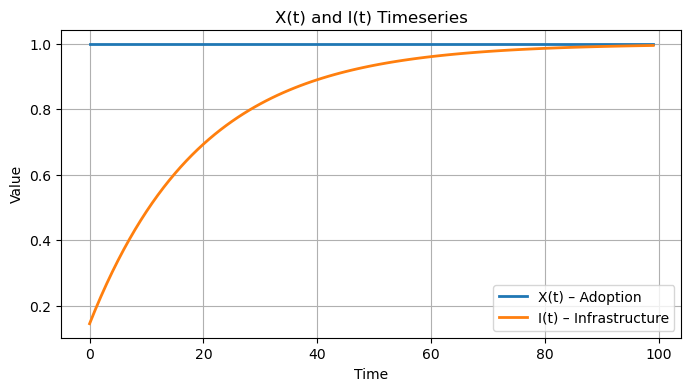

In [32]:
X_t, I_t, df = ER1_Timeseries_Tuple

plt.figure(figsize=(8, 4))
plt.plot(X_t, label="X(t) – Adoption", linewidth=2)
plt.plot(I_t, label="I(t) – Infrastructure", linewidth=2)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("X(t) and I(t) Timeseries")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
def run_network_trial(
    X0_frac: float,
    ratio: float = 2.0,
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 200,
    network_type: str = "ER",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    k: int = 30,
    seed: int | None = None,
    tol: float = 1e-3,
    patience: int = 30,
    collect: bool = True,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> float:
    """Run a single realisation and return final adoption fraction.

    Preserves the intended initial payoff ratio via a0 = ratio*b - beta_I*I0.
    Includes basic stability-based early stopping.
    """
    initial_ev = int(round(X0_frac * n_nodes))
    a0 = ratio * b - beta_I * I0

    model = EVStagHuntModel(
        initial_ev=initial_ev,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        k=k,
        collect=collect,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    stable_steps = 0
    prev_X = None
    prev_I = None
    for _ in range(T):
        model.step()
        X = model.get_adoption_fraction()
        I = model.infrastructure
        if prev_X is not None and prev_I is not None:
            if abs(X - prev_X) < tol and abs(I - prev_I) < tol:
                stable_steps += 1
            else:
                stable_steps = 0
        prev_X, prev_I = X, I
        if X in (0.0, 1.0) and stable_steps >= 10:
            break
        if stable_steps >= patience:
            break

    X_traj = []  # store adoption over time

    for _ in range(T):
        model.step()
        X = model.get_adoption_fraction()
        if collect:
            X_traj.append(X)
        # stability check...
    
    if collect:
        return np.array(X_traj)  # return trajectory
    else:
        return model.get_adoption_fraction() 

In [58]:
def _row_for_time_task(args: Dict) -> np.ndarray:
    """Worker to compute adoption over time for a fixed X0.

    Returns an array of shape (len(time_points),) for this X0.
    """
    X0 = args["X0"]
    beta_I = args["beta_I"]
    b = args["b"]
    g_I = args["g_I"]
    T = args["T"]
    network_type = args["network_type"]
    n_nodes = args["n_nodes"]
    p = args["p"]
    m = args["m"]
    batch_size = args["batch_size"]
    init_noise_I = args["init_noise_I"]
    strategy_choice_func = args["strategy_choice_func"]
    tau = args["tau"]
    time_points = args["time_points"]

    # We'll store the mean adoption over batches for each time point
    X_time = np.zeros((len(time_points),), dtype=float)

    for b_idx in range(batch_size):
        seed_j = np.random.randint(0, 2**31 - 1)
        # run_network_trial should now optionally return the full trajectory
        X_traj = run_network_trial(
            X0_frac=X0,
            beta_I=beta_I,
            b=b,
            g_I=g_I,
            T=T,
            network_type=network_type,
            n_nodes=n_nodes,
            p=p,
            m=m,
            seed=seed_j,
            collect=True,  # collect full X(t)
            strategy_choice_func=strategy_choice_func,
            tau=tau,
        )
        # X_traj assumed to be length T
        X_time += X_traj[time_points]

    # Average over batch
    X_time /= batch_size
    return X_time

In [59]:
def phase_sweep_X0_vs_time(
    X0_values: Iterable[float],
    time_points: Iterable[int],
    *,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.05,
    T: int = 250,
    network_type: str = "BA",
    n_nodes: int = 120,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    max_workers: int | None = None,
    backend: str = "process",
    seed: int = 42,
) -> np.ndarray:
    """
    Compute adoption X(t) over time for each X0 value.

    Returns an array of shape (len(time_points), len(X0_values)),
    rows = time points, columns = X0_values.
    """
    X0_values = list(X0_values)
    time_points = list(time_points)
    X_over_time = np.zeros((len(time_points), len(X0_values)), dtype=float)

    # Prepare tasks per X0
    tasks: List[Dict] = []
    for X0 in X0_values:
        tasks.append({
            "X0": X0,
            "beta_I": beta_I,
            "b": b,
            "g_I": g_I,
            "T": T,
            "network_type": network_type,
            "n_nodes": n_nodes,
            "p": p,
            "m": m,
            "batch_size": batch_size,
            "init_noise_I": init_noise_I,
            "strategy_choice_func": strategy_choice_func,
            "tau": tau,
            "seed": seed,
            "time_points": time_points,  # new
        })

    if max_workers is None:
        try:
            max_workers = os.cpu_count() or 1
        except Exception:
            max_workers = 1

    Executor = ProcessPoolExecutor if backend == "process" and max_workers > 1 else ThreadPoolExecutor

    # Submit tasks
    if max_workers > 1:
        with Executor(max_workers=max_workers) as ex:
            futures = [ex.submit(_row_for_time_task, args) for args in tasks]
            for j, fut in enumerate(futures):
                col = fut.result()
                X_over_time[:, j] = col
    else:
        for j, args in enumerate(tasks):
            col = _row_for_time_task(args)
            X_over_time[:, j] = col

    return X_over_time

In [63]:
BA1_X0_time_array = phase_sweep_X0_vs_time(
    X0_values= np.linspace(0.2, 0.9, 10, dtype= float),
    time_points= np.linspace(1, 100, 100, dtype= int),
    beta_I = 1.5,
    b= 2.0,
    g_I = 0.05,
    T= 250,
    network_type = "BA",
    n_nodes = 300,
    p= 0.1,
    m = 2,
    batch_size = 16,
    init_noise_I= 0.1,
    strategy_choice_func= "logit",
    tau= 2.0,
    max_workers = 1,
    backend="process",
    seed=42,
)

In [64]:
def plot_X0_time_heatmap(df: pd.DataFrame, out_path: str | None = None):
    """
    Plot a heatmap of X(t) over (X0, time) from a DataFrame generated by phase_sweep_X0_vs_time.

    df: DataFrame where
        - df.index are time points
        - df.columns are X0 values
        - df.values are X(t)
    """

    # Extract coordinates
    time_points = df.index.values.astype(float)
    X0_values = df.columns.values.astype(float)
    X_over_time = df.values.astype(float)

    # Plot
    plt.figure(figsize=(7, 4))
    im = plt.imshow(
        X_over_time,
        origin="lower",
        extent=[X0_values.min(), X0_values.max(),
                time_points.min(), time_points.max()],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma"
    )

    plt.colorbar(im, label="Adoption X(t)")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("Time step")
    plt.title("Network adoption over time: X(t) over X0 and time")

    # Save
    if out_path is None:
        out_path = os.path.join(os.getcwd(), "X0_time_heatmap.png")

    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()

    return out_path

In [69]:
X0_values= np.linspace(0.2, 0.9, 10, dtype= float)
time_points= np.linspace(1, 100, 100, dtype= int)
BA1_X0_time_df = pd.DataFrame(BA1_X0_time_array, index=time_points, columns=X0_values)
plot_X0_time_heatmap(df=BA1_X0_time_df, out_path = "BA1_X0_time_heatmap2.png")

'BA1_X0_time_heatmap2.png'

In [73]:
def run_timeseries_trial(
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    seed: Optional[int] = None,
    policy: Optional[Callable] = None,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """Run a single simulation and return X(t), I(t), and the model dataframe."""

    scenario = {
        # Either provide `ratio` to pin the initial a_I/b, or explicit `a0`.
        # Defaults here mirror the classroom-friendly values.
        # If `ratio` is present, we compute `a0 = ratio*b - beta_I*I0`.
        "a0": 2.0,
        "ratio": None,
        "beta_I": 3.0,
        "b": 1.0,
        "g_I": 0.1,
        "I0": 0.05,
        "network_type": "random",
        "n_nodes": 100,
        "p": 0.05,
        "m": 2,
        "x0_frac": 0.0,
        "collect": True,
        "init_method": "random",
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    # Compute a0 from ratio if provided to preserve initial payoff ratio
    a0_for_model = scenario["a0"]
    if scenario.get("ratio") is not None:
        a0_for_model = float(scenario["ratio"]) * float(scenario["b"]) - float(scenario["beta_I"]) * float(scenario["I0"])

    model = EVStagHuntModel(
        a0=a0_for_model,
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        I0=scenario["I0"],
        seed=seed,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        collect=True,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    if scenario.get("X0_frac", 0.0) > 0.0:
        set_initial_adopters(
            model,
            scenario["X0_frac"],
            method=scenario.get("init_method", "random"),
            seed=seed,
        )

    for t in range(T):
        if policy is not None:
            policy(model, t)
        model.step()

    df = model.datacollector.get_model_vars_dataframe().copy()
    return df["X"].to_numpy(), df["I"].to_numpy(), df

In [74]:
scenario = {
    "network_type": "ER",  # "ER", "BA", "WS", "grid"
    "n_nodes": 300,
    "p": 0.1,  # only used for ER or WS
    "m": 2, 
    "k": 30,    # only used for BA
    "beta_I": 2.0,
    "b": 2.0,
    "g_I": 0.05,
    "I0": 0.1,
}

X0_values = np.linspace(0.2, 0.9, 10)  # sweep from 20% to 90%
n_trials = 50
T = 200

probabilities = []

for X0 in X0_values:
    scenario["X0_frac"] = X0
    final_X = []

    for i in range(n_trials):
        seed = 42 + i
        X, I, _ = run_timeseries_trial(T=T, scenario_kwargs=scenario, seed=seed)
        final_X.append(X[-1])  # store final adoption

    final_X = np.array(final_X)
    prob = np.mean(final_X >= high_adoption_threshold)
    probabilities.append(prob)

In [ ]:
final_X = np.array(final_X)
high_adoption_threshold = 0.8
prob_high_adoption = np.mean(final_X >= high_adoption_threshold)

print("Probability of reaching high adoption:", prob_high_adoption)
print("Mean final adoption:", final_X.mean())
print("Std final adoption:", final_X.std())

Probability of reaching high adoption: 0.0
Mean final adoption: 0.0
Std final adoption: 0.0
